In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from glob import glob
from tqdm import trange
from typing import List,Tuple
from data_processing.data_loader import dataset_loader
from losses import euclidean_distance_loss,endpoint_loss
from models import endpoint_in_model
from matplotlib import pyplot as plt
import numpy as np
from config import params
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

os.environ['CUDA_VISIBLE_DEVICES']="5,6,7"

2.3.0
Num GPUs Available:  8


In [2]:
dataset_dir='/netpool/work/gpu-3/users/malyalasa/New_folder/tf_records'
ds_loader = dataset_loader(tfrec_dir=dataset_dir,batch_size=32)
ds_train,ds_valid,ds_test= ds_loader.build_dataset()

Number of records, Train files:408, validation files:88, Test Files:87
Building Dataset.......

((TensorSpec(shape=(None, 1536, 1536), dtype=tf.int8, name=None),
  TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None)),
 TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None))


In [3]:
list_mask=[[1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.]]


In [4]:
#pp_model=tf.keras.models.load_model('/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210625_053926-21xquqgr/files/model-best.h5',compile=False)
#pp_model = nn()
#pp_model.load_weights()
pp_model = tf.keras.models.load_model('/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/latest-run/files/model-best.h5',compile=False,custom_objects={'CustomMaskLayer':endpoint_in_model.CustomMaskLayer})
#pp_model=tf.keras.models.load_model('/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210625_053926-21xquqgr/files/model-best.h5',compile=False)
opt = tf.keras.optimizers.Adam(learning_rate=0.02)
pp_model.compile(
        optimizer=opt, 
        loss=[euclidean_distance_loss,endpoint_loss],
        loss_weights=params.get("loss_weights"), metrics=params.get("metric")
    )#pp_model.summary()
test_loss,test_accuracy = pp_model.evaluate(ds_test)

42/42 [==============================] - 1s 33ms/step - loss: 0.2345 - accuracy: 1.0000


In [5]:
predictions = pp_model.predict(ds_test)
np.shape(predictions)

(1329, 25, 2)

In [6]:
def get_test_ds_size(ds_test):
    num_of_samples=0
    for input_batch, output_batch in ds_test:
        for i in range(0,len(input_batch[0].numpy())):
            num_of_samples+=1
    return num_of_samples

def get_np_test_ds(ds_test):

    samples = get_test_ds_size(ds_test)
    np_tst_gridmap = np.zeros(shape=(samples,1536,1536))
    np_tst_grid_org_res = np.zeros(shape=(samples,3))
    np_tst_left_bnd = np.zeros(shape=(samples,25,2))
    np_tst_right_bnd = np.zeros(shape=(samples,25,2))
    np_tst_car_odo = np.zeros(shape=(samples,3))
    np_tst_init_path = np.zeros(shape=(samples,25,2))
    np_tst_opt_path = np.zeros(shape=(samples,25,2))
    list_tst_file_details = []

    j=0
    for input_batch, output_batch in ds_test:
        
        for i in range(0,len(input_batch[0].numpy())):
            np_tst_gridmap[j]=input_batch[0][i].numpy()
            np_tst_grid_org_res[j] = input_batch[1][i].numpy()
            np_tst_left_bnd[j] = input_batch[2][i].numpy()
            np_tst_right_bnd[j] = input_batch[3][i].numpy()
            np_tst_car_odo[j] = input_batch[4][i].numpy()
            np_tst_init_path[j] = input_batch[5][i].numpy()
            list_tst_file_details.append(input_batch[6][i])

            np_tst_opt_path[j] = output_batch[i].numpy()
            j=j+1   
    return np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path

In [7]:
np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path =get_np_test_ds(ds_test)


In [8]:
def plot_scene(features):    
    grid_map = features["grid_map"]
    grid_org = features["grid_org_res"] #[x,y,resolution]
    left_bnd = features["left_bnd"]
    right_bnd = features["right_bnd"]
    init_path = features["init_path"]
    opt_path = features["opt_path"]
    car_odo = features["car_odo"]

    predict_path = features["predictions"]
    file_details=features["file_details"]

    #print(type(grid_map))
    
    plt.figure(figsize=(10, 10))
    #ax=fig.add_subplot(1,1,1)

    res = grid_org[2]
    plt.plot((left_bnd[:,0]-grid_org[0])/res,(left_bnd[:,1]-grid_org[1])/res,'-.', color='magenta',markersize=0.5, linewidth=0.5)

    plt.plot((init_path[:,0]-grid_org[0])/res,(init_path[:,1]-grid_org[1])/res,'o-', color='lawngreen',markersize=1, linewidth=1)
    plt.plot((opt_path[:,0]-grid_org[0])/res,(opt_path[:,1]-grid_org[1])/res,'--', color='yellow',markersize=1, linewidth=1)

    plt.plot((predict_path[:,0]-grid_org[0])/res,(predict_path[:,1]-grid_org[1])/res,'--', color='orange',markersize=1, linewidth=1)

    plt.plot((right_bnd[:,0]-grid_org[0])/res,(right_bnd[:,1]-grid_org[1])/res, '-.',color='magenta',markersize=0.5, linewidth=0.5)

    plt.plot((car_odo[0]-grid_org[0])/res,(car_odo[1]-grid_org[1])/res,'r*', color = 'red',markersize=8)


    plt.legend(['Left bound', 'gt_init_path', 'gt_opt_path','predicted_path','right bound', 'car_centre'], loc='lower left')

    plt.imshow(grid_map,origin="lower")

    

    plt.title(f"{file_details}\nTest Index: {features['testidx']}")
    save_fig_dir = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/all_testset_results'
    
    plt.savefig(f"{save_fig_dir}/Test_index_{features['testidx']}.png",dpi=300)

    plt.close()
    #print(type(file_details))

    #return ax,fig

In [14]:
print(len(predictions[0:5]))

5


In [9]:
#test_idx= 856#12#785#1000#28#530#143#120#15#1300#530#320#50#1050
%matplotlib agg
for test_idx in trange(0,len(predictions)):
    test_data={}
    test_data["grid_map"]= np_tst_gridmap[test_idx]
    test_data["grid_org_res"]= np_tst_grid_org_res[test_idx]
    test_data["left_bnd"]= np_tst_left_bnd[test_idx]
    test_data["right_bnd"]= np_tst_right_bnd[test_idx]
    test_data["car_odo"]= np_tst_car_odo[test_idx]
    test_data["init_path"]= np_tst_init_path[test_idx]
    test_data["opt_path"]= np_tst_opt_path[test_idx]
    test_data["predictions"] = predictions[test_idx]
    test_data["file_details"] = list_tst_file_details[test_idx]
    test_data["testidx"] = test_idx
#print(test_data["left_bnd"])
    plot_scene(test_data)

100%|██████████| 1329/1329 [19:59<00:00,  1.11it/s]


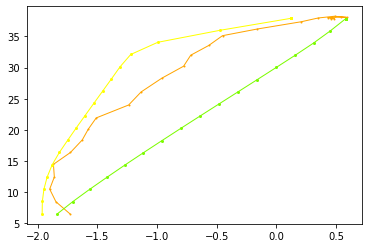

In [11]:
plt.plot(predictions[test_idx][:,0],predictions[test_idx][:,1],'-o', color = 'orange', markersize=1, linewidth=1)
plt.plot(np_tst_init_path[test_idx][:,0],np_tst_init_path[test_idx][:,1],'-o', color='lawngreen',markersize=2, linewidth=1)
plt.plot(np_tst_opt_path[test_idx][:,0],np_tst_opt_path[test_idx][:,1],'-o', color='yellow',markersize=2, linewidth=1)
plt.show()